## Document Classification using NLP, Machine Learning
### Objective
Perform document classification into four defined categories (World, Sports, Business, Sci/Tech). Compare the classifier accuracy with different models ranging from Naïve Bayes to Convolutional Neural Network (CNN) and RCNN. By making use of different feature engineering techniques and extra Natural Language Processing (NLP) features create an accurate text classifier.

### Document/Text Classification
Document/Text classification is an important task that has use cases in many real-world problems. Assigning topics to documents like news article, books, webpages, social media post has many applications like spam filtering, sentiment analysis, tagging customer queries, fake news detection etc. Natural language's vastly large size, unrestrictive nature, and ambiguity led to two problems when using standard parsing approaches that relied purely on symbolic, hand-crafted rules: unmanageable numerous rules and inability to understand ungrammatical text something which is human comprehensible easily. A problem statement apt for machine learning. NLP is a branch of data science that consists of systematic processes for analyzing, understanding, and deriving information from the text data in a smart and efficient manner. By utilizing NLP and its components, one can organize the massive chunks of text data, perform numerous automated tasks and solve a wide range of problems such as – automatic summarization, machine translation, named entity recognition, relationship extraction, sentiment analysis, speech recognition, and topic segmentation etc.

### Previous Research in this area
In the last few years, neural networks based on dense vector representations have been producing superior results on various NLP tasks. This trend is sparked by the success of word embeddings and deep learning methods. The traditional NLP systems which were formed upon machine learning rules have always relied majorly on hand-crafted features whereas deep learning has provided substantial difference with multi-level automatic feature representation learning. With time as the success of a simple deep learning framework was established over conventional machine learning methodologies, several NLP tasks have changed their focus on this new area. Not only complex deep learning based algorithm been proposed but applications such as semantic role labeling and named entity recognition have been improved greatly.  


In [29]:
import pandas, numpy, string, textblob
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost
from keras import layers, models, optimizers
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt

### Dataset
The chosen dataset is the ‘AG News’ dataset consisting of 1,20,000 news articles for training categorized in four categories- World, Sports, Business, Sci/Tech. It also includes 7600 testing samples in csv format. I have used pandas library to load the dataset.

In [7]:
#Load training data
df_train = pandas.read_csv('dataset/ag_news/train.csv')
# df_train = df_train.truncate(after=10000)
#Load testing data
df_test = pandas.read_csv('dataset/ag_news/test.csv')

In [8]:
df_train.head()
df_train.info()
df_count = df_train.groupby(['Class Index'], as_index = False).agg({'Title': 'count', 'Description': 'count'})
df_count.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
Class Index    120000 non-null int64
Title          120000 non-null object
Description    120000 non-null object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


,Class Index,Title,Description
0,1,30000,30000
1,2,30000,30000
2,3,30000,30000
3,4,30000,30000


### Text Pre-processing
It is predominantly comprised of three steps:
1. Tokenization – It is about splitting strings of text into smaller pieces, or “tokens”. Paragraphs can be tokenized into sentences and sentences can be tokenized into words. 
2. Noise Removal – I have further cleaned up the text in this step. I have achieved so by removing punctuations, stop words, extra whitespaces and many other data points which was irrelevant to the NLP tasks. The NLTK library has inbuild functionalities for many such operations. A brief description of few of the steps taken is as:
    - Removed HTML tags: Since articles scrapped from web are likely to contain HTML tags, therefore have used Python package BeautifulSoup to remove HTML tags.
    - Remove stop words, accented characters and punctuation: As stop words, punctuations, extra whitespaces and accented characters do not add useful information to our text processing algorithm, therefore have removed them using modules such as Unicode and spaCy.
    - Treating Numbers: In our application numbers do not provide any significant knowledge and so, we have removed them. Firstly, in order to standardize the text, have converted number words to numeric form and then removed them from the textual data.
3. Normalization – In this process, I have standardized the text into uniform sequence. I have converted the text to lowercase and using NLTK libraries performed stemming and lemmatization. Stemming refers to removing the suffixes attached to a word and lemmatization refers to conserving the root word of a word. We have used lemmatization for our textual data because that performed better with the pre-trained word embedding

In [9]:
import re, unidecode
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

# Needed only once
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text
def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result
def remove_slash_with_space(text): 
    return text.replace('\\', " ")
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 
def text_lowercase(text): 
    return text.lower()     
def remove_whitespace(text): 
    return  " ".join(text.split()) 
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return ' '.join(filtered_text)
def stem_words(text): 
    stemmer = PorterStemmer() 
    word_tokens = word_tokenize(text) 
    stems = [stemmer.stem(word) for word in word_tokens] 
    return ' '.join(stems)
def lemmatize_words(text): 
    lemmatizer = WordNetLemmatizer() 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return ' '.join(lemmas) 


In [10]:
# Perform preprocessing
def perform_preprocessing(text):
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = text_lowercase(text)
    text = remove_slash_with_space(text)
    text = remove_punctuation(text)
    # text = stem_words(text)
    text = lemmatize_words(text)
    text = remove_whitespace(text)
    return text

df_train['Title'] = df_train['Title'].apply(perform_preprocessing)
df_train['Description'] = df_train['Description'].apply(perform_preprocessing)
df_test['Title'] = df_test['Title'].apply(perform_preprocessing)
df_test['Description'] = df_test['Description'].apply(perform_preprocessing)


### Train test split

In [11]:
X_train = df_train['Description']
X_test = df_test['Description']
y_train = df_train['Class Index']
y_test = df_test['Class Index']

### Feature Engineering
Text files are actually series of words (ordered). In order to run machine learning algorithms we need to convert the text files into numerical feature vectors.  

We will implement the following different ideas in order to obtain relevant features from our dataset.

1. CountVectors – I have used scikit-learn library’s CountVectorizer module to vectorize sentences. It generates vocabulary for all unique words of sentence. From this count of words, a feature vector is created. This essentially is the Bag of Words BOW model. 

In [12]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)
X_train_count =  count_vect.transform(X_train)
X_test_count =  count_vect.transform(X_test)

2. TF-IDF Vectors Word level - Now in order to assign weightage to the above feature vector, we have used Term Frequency – Inverse Document Frequency logic. We have given a score to the words based on its Term Frequency (#words/ #Total words) and its Inverse Frequency, i.e. presence in each of the documents. It low scores repetitive words.

![title](images/tfidf.png)

In [13]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

3. TF-IDF Vectors N-Gram level – In this approach for better results, have combined N (>= 2) words to form N-grams. Bigrams (N=2) are the most optimal and best convey most important information among other N-grams. 

In [14]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

4. TF-IDF Vectors Character level- character level

In [15]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X_train)
X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
X_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test) 

5. Text / NLP based features - I tried adding additional NLP features namely word count, character count, average word density, title word count but I found them harmful to model accuracy. So, I have removed them. 

In [16]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

encoder = preprocessing.LabelBinarizer()
encoder.fit(y_train)
y_train_bi = encoder.transform(y_train)
y_test_bi = encoder.transform(y_test)

###	MODEL SELECTION AND TRAINING
#### Classical models (Used as a Baseline Model)

In [17]:
def train_model(classifier, X_train, y_train, X_test, y_test, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(X_train, y_train)
    # predict the labels on validation dataset
    predictions = classifier.predict(X_test)
    return metrics.accuracy_score(predictions, y_test)

Naïve Bayes Classifier – This classification technique is based on Bayes’ Theorem and assumes independence among the predictors

![title](images/nb.png)

NB, Count Vectors:  0.8956578947368421
NB, WordLevel TF-IDF:  0.8835526315789474
NB, N-Gram Vectors:  0.8797368421052632
NB, CharLevel Vectors:  0.8443421052631579


<BarContainer object of 4 artists>

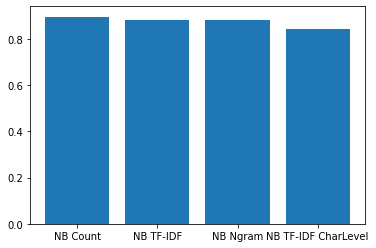

In [18]:
# Naive Bayes on Count Vectors
accuracy1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB, Count Vectors: ", accuracy1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB, WordLevel TF-IDF: ", accuracy2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("NB, N-Gram Vectors: ", accuracy3)

# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("NB, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['NB Count', 'NB TF-IDF','NB Ngram', 'NB TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

Logistic Regression – This model uses a logistic/sigmoid function to calculate the probabilities of different values of the categorical dependent variable in presence of one or more predictors. Logit function is an estimation of log of odds in the favor of event and outputs a s-shaped curve with probability estimates.


C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR, Count Vectors:  0.9067105263157895
LR, WordLevel TF-IDF:  0.8997368421052632
LR, N-Gram Vectors:  0.8973684210526316
LR, CharLevel Vectors:  0.8828947368421053


<BarContainer object of 4 artists>

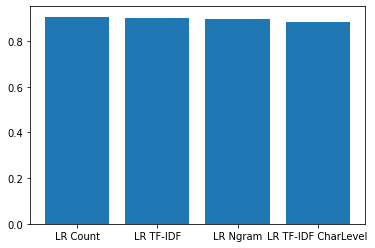

In [19]:
# Logistic Regression on Count Vectors
accuracy1 = train_model(linear_model.LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
print("LR, Count Vectors: ", accuracy1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy2 = train_model(linear_model.LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR, WordLevel TF-IDF: ", accuracy2)

# Logistic Regression on Ngram Level TF IDF Vectors
accuracy3 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("LR, N-Gram Vectors: ", accuracy3)

# Logistic Regression on Character Level TF IDF Vectors
accuracy4 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("LR, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['LR Count', 'LR TF-IDF','LR Ngram', 'LR TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

Bagging Model (Random Forest) - Random Forest models are a type of ensemble models, particularly bagging models. The main aim of these models is to reduce the overfitting. They work towards reducing the model complexity. 

In [20]:
# RF on Count Vectors
accuracy1 = train_model(ensemble.RandomForestClassifier(), X_train_count, y_train, X_test_count, y_test)
print("RF, Count Vectors: ", accuracy1)

# RF on Word Level TF IDF Vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("RF, WordLevel TF-IDF: ", accuracy2)

C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Saurabh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors:  0.8602631578947368
RF, WordLevel TF-IDF:  0.8571052631578947


XG Boost - Boosting models are type of ensemble models and work to improve the model prediction rates. This model is meta-algorithm for reducing bias and variance in supervised learning. One of its strong points is that it converts weak learner i.e. classifiers slightly correlated to the true classification into stronger ones. 

In [ ]:
# Extereme Gradient Boosting (XG boost) on Count Vectors
accuracy3 = train_model(xgboost.XGBClassifier(), X_train_count.tocsc(), y_train, X_test_count.tocsc(), y_test)
print("Xgb, Count Vectors: ", accuracy3)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accurac4 = train_model(xgboost.XGBClassifier(), X_train_tfidf.tocsc(), y_train, X_test_tfidf.tocsc(), y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy4)

# # Extereme Gradient Boosting on Character Level TF IDF Vectors
# accuracy = train_model(xgboost.XGBClassifier(), X_train_tfidf_ngram_chars.tocsc(), y_train, X_test_tfidf_ngram_chars.tocsc(), y_test)
# print("Xgb, CharLevel Vectors: ", accuracy)
df = {'ModelType': ['RF count', 'RF TF-IDF','XG Count', 'XG TF-IDF' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

To further improve the performance of the model and studying the recent advancement in NLP, I used the following Neural network models for the problem statement-
### Shallow Neural Network
Neural networks or feedforward neural networks. These have multiple layers of neurons arranged in fashion similar to that of human brain. The input feature vector is processed at each layer and then forwarded to the next hidden layer. The output for the next layer is created by multiplying the input with weight w and bias b. All of this summed up and then passed on to the activation function. I have rectified linear unit (ReLU) function. The algorithm initializes the weights and trains them using backpropagation. We reduced the error of the predicted output, it uses optimization methods like the gradient descent.

![title](images/nb.png)
#### Parameters
In order to have minimum training loss and maximize the accuracy, I have specified epochs of 10. So, on an average I have trained my model in 10 rounds. Also, I have setup the batch size as 50. This essentially means that I have used 50 samples in one forward and backward pass to optimize the computation rate and memory consumption. Validation split of 10 % is used, this is a split of training data to calculate loss function and should be kept apart from testing set in order to not let testing set to influence the model. 

In [21]:
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Train on 108000 samples, validate on 12000 samples
Epoch 1/10
108000/108000 [==============================] - 11s 98us/step - loss: 0.3522 - accuracy: 0.8889 - val_loss: 0.2851 - val_accuracy: 0.8987

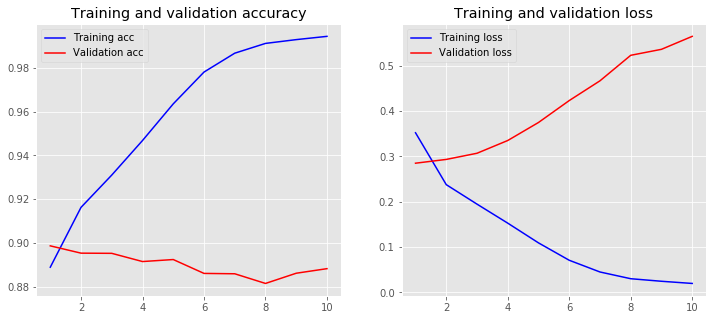

In [22]:
vocab_size = X_train_tfidf.shape[1]
num_labels = 4
batch_size = 100
# Neural network on TFIDF
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train_tfidf, y_train_bi,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_tfidf, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tfidf, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)


In [23]:
vocab_size = 15000
num_labels = 4
batch_size = 100
maxlen = 200

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index

X_train_token = sequence.pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_token = sequence.pad_sequences(X_test_token, padding='post', maxlen=maxlen)
embedding_dim = 300

### More Feature Engineering
#### Word Embeddings (It has been found to work well with neural networks)
In this I have sought to represent words in the form of vectors. It preserves contextually similar words and reduces the high dimensional word features to low dimensional feature vectors. Deep learning model namely RNN and CNN use it in their algorithm. I have used GIoVe to create word embedding of a text. The module of Word2Vec has a preprocessing module, a continuous bag of words and skip-grams. The latter two features are essentially shallow neural networks.

#### Using Pretrained Word Embeddings
Among the most popular methods are Word2Vec developed by Google and GloVe (Global Vectors for Word Representation) developed by the Stanford NLP Group.

I have used Glove since it is faster, although less accurate than Word2Vec. GloVe uses co-occurrence matrix and matrix factorization to acheive dimensionality reduction

Download-glove(822mb) - http://nlp.stanford.edu/data/glove.6B.zip
 
Extract the zip under dataset/

In [24]:
# create embedding matrix using pre-trained word vectors
def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = numpy.zeros((vocab_size, embedding_dim))

    with open(filepath,'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = numpy.array(
                    vector, dtype=numpy.float32)[:embedding_dim]

    return embedding_matrix

#basic new word embed
embedding_matrix = create_embedding_matrix('word_embeddings/glove.6B.300d.txt',tokenizer.word_index, embedding_dim)
nonzero_elements = numpy.count_nonzero(numpy.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)


0.7124104223770681


In [25]:
# Shallow neural network basic with word embedding matrix
embedding_dim = 300

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


C:\Users\Saurabh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 108000 samples, validate on 12000 samples
Epoch 1/10
108000/108000 [==============================] - 14s 134us/step - loss: 0.3789 - accuracy: 0.8720 - val_loss: 0.2854 - val_accuracy: 0.8988 - ETA: 20s - loss: 1.0372 - accuracy: 0.6076

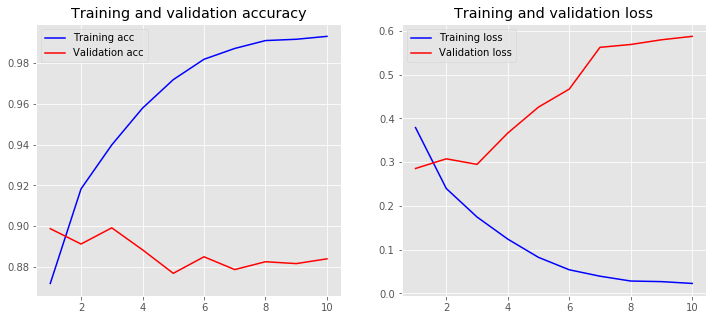

In [26]:
plot_history(history)

### Deep neural network 
I have used keras for setting up the deep neural network. It relies on highly dedicated or specialized tensor libraries: Theano and tensor flow 2.1. keras doesn’t handle tensor manipulation and differentiation. The embedding layer takes the precalculated integers, uses the embedding matrix of the pretrained vectors to assigns the dense vectors. This result is fed into flatten layer for sequential input. From there it is fed to dense layer. I have also used GlobalMaxPooling ID after the embedding. Thisreduces the sample size by choosing maximum value of all the features.

#### Convolutional Neural Network (Covnets)
It is a specialized deep neural network to identify peculiar trends which is used to discern the most important information in a sentence. The hidden layers called convolutional layer starts with a sample of input features of the dimensions of kernel filters. The dot product between the patch and multiplied weights of filter is taken. I have used one dimensional CNN which is unaffected by translations i.e. it can understand patterns at different position. The patch of filters slide filter slide over embedding matrix and extracts a specific pattern of n-gram. So, the kernels keep covering larger part of document until it creates global summarization of features A max-pooling strategy to subsample the input using max function is applied after every convolutional layer. It has two uses – it provides fixed-length output and reduces output dimensionality of most important features. Such layers are stacked multiple times to improve mining of abstract information.

![title](images/cnn.png)

In [27]:
# Deep Neural networks CNN
model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train_token, y_train_bi,
                    batch_size=30,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

C:\Users\Saurabh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 108000 samples, validate on 12000 samples
Epoch 1/10
108000/108000 [==============================] - 54s 501us/step - loss: 0.3317 - accuracy: 0.8885 - val_loss: 0.2489 - val_accuracy: 0.9118

### Saving Model
#### Save the model as well as tokenizer.

We have to save our tokenizer because it is our vocabulary. The same tokenizer and vocabulary have to be used for accurate prediction.

In [32]:
# creates a HDF5 file 'my_model.h5'
model.model.save('save/my_model.h5')

# Save Tokenizer i.e. Vocabulary
with open('save/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Recurrent Neural Network Bidirectional GRU
In RNN the activation outputs are propagated in both directions. It results in looping which provides a state to neurons giving it ability to remember the learnings. This memory is what gives the power to RNN but also impose the problem of Vanishing Gradient. The problem is slow learning rate and parameter tuning due to learning with large no. of layers. To solve this LSTMs (Long short term memory) is used but it often complex and slow computationally. A newer technique GRU is used in this paper. GRU exposes complete memory and has only 2 gates instead of 3 in case of LSTM. It provides similar performance as LSTM while faster to train.

![title](images/rnn.png)

In [ ]:
# Bi directional rnn gru

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Bidirectional(layers.GRU(100)))
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

### Hyper Parameter Tuning
To improve the model, I further resorted to trying different feature vectors and other combination of hyperparameter tuning. Tuning the paramters is an important step as I found that what works for one problem may not be best for another. I used Randomized Grid search for tuning. It takes lists of parameters and it runs the model with each parameter combination. Then I used the Keras classifier to create keras models. Doing so we get access to cross-validation technique of scikit-learn library. I used k-fold cross-validation. I have used k in the range of 10 to 15. This essentially divides my dataset into k sets of which k-1 sets are used for training the model and the remaining one set is used for model testing. This enabled me to run k different runs, where each partition is once used as a testing set. The end result is I got the parameter values which provided the best performances which I used in my final model.

In [42]:
# #basic new 3 cnn tuned
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(512))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(4))
    model.add(layers.Activation('softmax'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
epochs = 20
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train_token, y_train_bi)

test_accuracy = grid.score(X_test_token, y_test_bi)
s = ('data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
print(output_string)


TypeError: 'dict' object is not callable

### Result
The model that gave me the best performance on the test data is was CNN with an accuracy of 90.87 % with 10 epochs. The model can be used to process any document and predict a class for it. Using some random news articles on the internet I found the predictions fairly correct.

### Conclusion
While the classical models provided a good accuracy the neural network models improved it further. With more data the deep learning models will outmatch classical models. Using word embedding provided an additional 2-3% improvement in accuracy and faster training time. CNN provided the best performance in neural networks but RNN still had good results. More training data could make RNN perform better than CNN. 

### Live Testing


#### Loading the best model

In [33]:
final_model = models.load_model('save/my_model.h5')
 
# load tokenizer
tokenizer = text.Tokenizer()
with open('save/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


C:\Users\Saurabh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [34]:
class_dict = {'0': 'World', '1': 'Sports','2': 'Business','3': 'Sci/Tech'}
inp = ["Former opener Aakash Chopra has revealed how the relationship between Sourav Ganguly and coach John Buchanan turned strenuous at Kolkata Knight Riders, to an extent that the former Australia coach wanted to remove the ex-India skipper as the captain of the side. Chopra, who was with KKR in 2008, said Buchanan and Ganguly started off a decent note before the relationship turned frosty over time as the team finished sixth in the first season.“In the first year of IPL, there was John Buchanan [as coach], [fellow Australian] Ricky Ponting was also there. Sourav Ganguly was the captain. I have seen this from close quarters – their relationship was alright to begin with, but it worsened [with time],” Chopra said on his YouTube channel."]
inp = [perform_preprocessing(x) for x in inp]
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

out = final_model.predict(inp_token)
predicted_label = numpy.argmax(out) 
print("Predicted label: " + class_dict.get(str(predicted_label)))

Predicted label: Sports
